**Imports**

In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as stats
from scipy.stats import gaussian_kde
import seaborn as sns
import cvxpy as cp
import numpy as np
from scipy.optimize import minimize
from sklearn import preprocessing

**Let's start**

In [175]:
df = pd.read_csv('2024_03_25_-_epfl_fin413_crypto_portfolio_construction_-_project_dataset.csv', skiprows=1,index_col='time')
df.index=pd.to_datetime(df.index)
df.head()

,ADA,BCH,BTC,DOGE,ETH,LINK,LTC,MANA,XLM,XRP,SPXT,XCMP,USSOC,VIX
time,,,,,,,,,,,,,,
2017-10-02,0.027392,0.008261,-0.000402,-0.023234,-0.023491,-0.181214,-0.027555,-0.203082,-0.062725,-0.024964,0.00388,0.00320,0.00168,-0.00631
2017-10-03,-0.194745,-0.042087,-0.019799,-0.026641,-0.016846,-0.033296,-0.021392,0.166436,-0.045385,0.000985,0.00220,0.00238,0.00126,0.00635
2017-10-04,0.050384,-0.115200,-0.022141,-0.008798,-0.000445,0.134588,-0.017833,-0.144464,-0.048348,0.050172,0.00131,0.00060,0.00501,0.01262
2017-10-05,-0.016903,-0.004159,0.024363,-0.006903,0.011348,0.033163,0.008200,-0.063668,0.226926,0.114754,0.00582,0.00778,0.00624,-0.04569
2017-10-06,-0.140799,0.025370,0.011686,0.016882,0.045222,0.155556,0.008521,-0.398374,0.268461,-0.019328,-0.00076,0.00075,0.00413,0.05005


In [176]:
weights = np.array([1/14] * 14)

In [177]:
datePP = '2021-09-11'
dateTr = '2022-11-21'
weights = np.array([1/14] * 14)

# Calculate cumulative returns for each asset
cumulative_returns = (1 + df).cumprod()
portfolio_cumulative_returns = cumulative_returns.dot(weights)
initial_portfolio_value = 100
portfolio_value_at_peak = initial_portfolio_value * portfolio_cumulative_returns.loc[datePP]
portfolio_value_at_trough = initial_portfolio_value * portfolio_cumulative_returns.loc[dateTr]

print(f"Total Portfolio Value at Peak Date ({datePP}): {portfolio_value_at_peak}")
print(f"Total Portfolio Value at Trough Date ({dateTr}): {portfolio_value_at_trough}")

Total Portfolio Value at Peak Date (2021-09-11): 3552.3382820701927
Total Portfolio Value at Trough Date (2022-11-21): 1007.7283104221767


As suggested by López de Prado, the number of observations used to estimate the covariance matrix should be significantly higher than the number of assets to avoid estimation errors due to noise.

López de Prado introduces the concept of the Minimum Track Record Length (MinTRL), which is the minimum number of observations required to estimate a covariance matrix reliably. The formula is given as:

MinTRL=N(N+1)/2

where N is the number of assets.

In your case, with 14 assets, the minimum track record length would be:

MinTRL=14(14+1)/2=105

This suggests that you should have at least 105 observations per asset to reliably estimate the covariance matrix

CODE FOR THE COV-VAR MATRIX:

In [178]:
np.set_printoptions()
np.set_printoptions(precision=2, formatter={'float': '{:0.2e}'.format})

In [179]:
window_size = 6 * 21 #(6 months of trading days)

index_datePP = df.index.get_loc(datePP)
index_dateTr = df.index.get_loc(dateTr)

window_ending_at_datePP = df.iloc[index_datePP-window_size+1 : index_datePP+1]
cov_matrix_datePP = window_ending_at_datePP.cov()

window_ending_at_dateTr = df.iloc[index_dateTr-window_size+1 : index_dateTr+1]
cov_matrix_dateTr = window_ending_at_dateTr.cov()




print("Covariance matrix at the peak date (datePP):")
print(np.array2string(cov_matrix_datePP.values, formatter={'float_kind': lambda x: "{:.2e}".format(x)}))

print("\nCovariance matrix at the trough date (dateTr):")
print(np.array2string(cov_matrix_dateTr.values, formatter={'float_kind': lambda x: "{:.2e}".format(x)}))

print("Covariance matrix at the peak date (datePP):")
print(cov_matrix_datePP)
print("\nCovariance matrix at the trough date (dateTr):")
print(cov_matrix_dateTr)

Covariance matrix at the peak date (datePP):
[[5.43e-03 4.09e-03 2.35e-03 4.69e-03 3.46e-03 5.07e-03 4.18e-03 4.72e-03
  4.06e-03 4.53e-03 1.15e-04 1.45e-04 -3.74e-04 -1.52e-03]
 [4.09e-03 5.28e-03 2.73e-03 4.84e-03 4.08e-03 5.66e-03 4.94e-03 5.05e-03
  4.33e-03 4.75e-03 1.06e-04 1.62e-04 -2.66e-04 -1.32e-03]
 [2.35e-03 2.73e-03 2.02e-03 2.89e-03 2.39e-03 3.21e-03 2.75e-03 2.89e-03
  2.36e-03 2.58e-03 6.11e-05 8.44e-05 -1.72e-04 -8.43e-04]
 [4.69e-03 4.84e-03 2.89e-03 7.77e-03 4.03e-03 5.39e-03 4.70e-03 5.21e-03
  4.53e-03 5.04e-03 1.43e-04 2.19e-04 -3.27e-04 -2.01e-03]
 [3.46e-03 4.08e-03 2.39e-03 4.03e-03 4.04e-03 4.97e-03 4.07e-03 4.39e-03
  3.50e-03 3.85e-03 7.62e-05 1.21e-04 -2.98e-04 -1.07e-03]
 [5.07e-03 5.66e-03 3.21e-03 5.39e-03 4.97e-03 7.59e-03 5.71e-03 6.22e-03
  4.85e-03 5.51e-03 1.01e-04 1.56e-04 -3.03e-04 -1.45e-03]
 [4.18e-03 4.94e-03 2.75e-03 4.70e-03 4.07e-03 5.71e-03 5.24e-03 5.07e-03
  4.15e-03 4.72e-03 9.19e-05 1.40e-04 -2.90e-04 -1.31e-03]
 [4.72e-03 5.05e-03 2.89

To clean the covariance matrix using the eigenvalue clipping method (also known as the eigenvalue capping method), we will follow these steps:

    -Compute the eigenvalues and eigenvectors of the covariance matrix.
    -Set a threshold for the eigenvalues. Typically, we can use the average eigenvalue as a threshold.
    -Cap all eigenvalues that are above this threshold to the value of the threshold.
    -Reconstruct the cleaned covariance matrix using the clipped eigenvalues and the original eigenvectors.

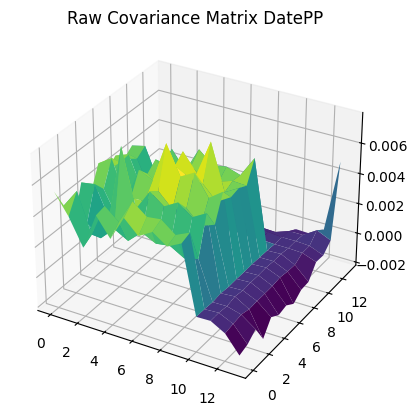

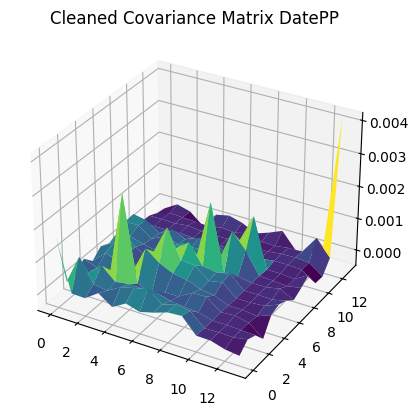

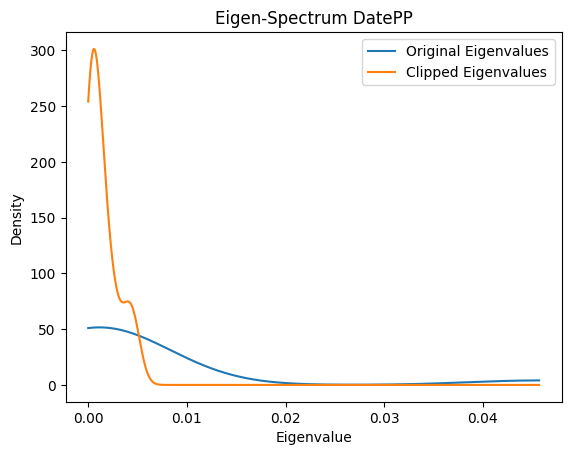

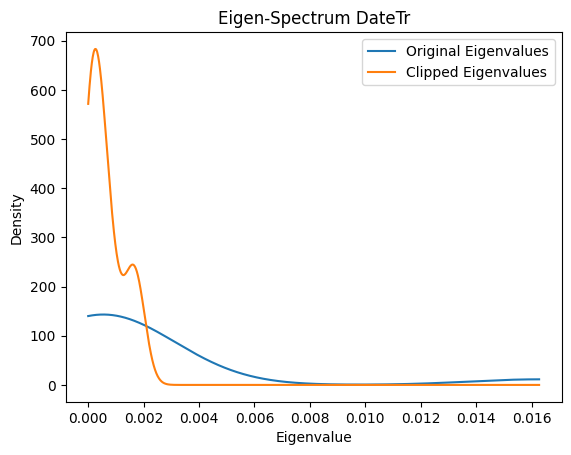

Condition Number - Raw DatePP: 15606.900922692488
Condition Number - Cleaned DatePP: 1484.4073085511466
Condition Number - Raw DateTr: 3800.722535541753
Condition Number - Cleaned DateTr: 398.17828752525696


In [180]:
def clean_covariance(cov_matrix):
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    # Compute the threshold as the average eigenvalue
    avg_eigenvalue = np.mean(eigenvalues)
    # Cap the eigenvalues
    clipped_eigenvalues = np.clip(eigenvalues, a_min=None, a_max=avg_eigenvalue)
    # Reconstruct the cleaned covariance matrix
    cleaned_cov_matrix = eigenvectors @ np.diag(clipped_eigenvalues) @ eigenvectors.T
    
    return cleaned_cov_matrix, eigenvalues, clipped_eigenvalues


cleaned_cov_matrix_datePP, eigenvalues_datePP, clipped_eigenvalues_datePP = clean_covariance(cov_matrix_datePP)
cleaned_cov_matrix_dateTr, eigenvalues_dateTr, clipped_eigenvalues_dateTr = clean_covariance(cov_matrix_dateTr)

def plot_3D_cov(cov_matrix, title):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x, y = np.meshgrid(range(cov_matrix.shape[0]), range(cov_matrix.shape[1]))
    ax.plot_surface(x, y, cov_matrix, cmap='viridis')
    plt.title(title)
    plt.show()

plot_3D_cov(cov_matrix_datePP, 'Raw Covariance Matrix DatePP')
plot_3D_cov(cleaned_cov_matrix_datePP, 'Cleaned Covariance Matrix DatePP')

def plot_kde_eigenvalues(eigenvalues, clipped_eigenvalues, title):
    eigenvalues_density = gaussian_kde(eigenvalues)
    clipped_eigenvalues_density = gaussian_kde(clipped_eigenvalues)
    x = np.linspace(min(eigenvalues), max(eigenvalues), 1000)
    plt.plot(x, eigenvalues_density(x), label='Original Eigenvalues')
    plt.plot(x, clipped_eigenvalues_density(x), label='Clipped Eigenvalues')
    plt.title(title)
    plt.xlabel('Eigenvalue')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

plot_kde_eigenvalues(eigenvalues_datePP, clipped_eigenvalues_datePP, 'Eigen-Spectrum DatePP')
plot_kde_eigenvalues(eigenvalues_dateTr, clipped_eigenvalues_dateTr, 'Eigen-Spectrum DateTr')

condition_number_raw_datePP = np.linalg.cond(cov_matrix_datePP)
condition_number_cleaned_datePP = np.linalg.cond(cleaned_cov_matrix_datePP)
condition_number_raw_dateTr = np.linalg.cond(cov_matrix_dateTr)
condition_number_cleaned_dateTr = np.linalg.cond(cleaned_cov_matrix_dateTr)

print(f"Condition Number - Raw DatePP: {condition_number_raw_datePP}")
print(f"Condition Number - Cleaned DatePP: {condition_number_cleaned_datePP}")
print(f"Condition Number - Raw DateTr: {condition_number_raw_dateTr}")
print(f"Condition Number - Cleaned DateTr: {condition_number_cleaned_dateTr}")

*3D Visualizations of Covariance Matrices*

The first two plots show 3D representations of the raw and cleaned covariance matrices for the DatePP. The z-axis represents the magnitude of the covariance between different assets (as represented by the x and y-axes).

    Raw Covariance Matrix DatePP: This plot shows the original covariance matrix before cleaning. It appears to have several peaks and valleys, indicating significant variance and covariance among the assets. Such variances and covariances could suggest the presence of both highly correlated and uncorrelated assets or even noise in the data.

    Cleaned Covariance Matrix DatePP: After cleaning, the covariance matrix shows a more uniform surface with fewer peaks, suggesting that extreme covariance values have been reduced. This "smoothing" is the result of clipping the eigenvalues, which limits the influence of components that may represent noise or unstable correlations.

*Kernel Density Plots of Eigen-Spectra*

The next two images show the kernel density estimation plots for the eigenvalues (eigen-spectra) of the covariance matrices. They provide insight into the distribution of the eigenvalues.

    Eigen-Spectrum DatePP: You can see that the original eigenvalues (blue line) have a distribution with a long right tail, indicating the presence of a few large eigenvalues and many small ones. The clipped eigenvalues (orange line) show a truncated distribution, where eigenvalues larger than the threshold are capped, resulting in reduced variance.

    Eigen-Spectrum DateTr: Similar to DatePP, the original eigenvalues have a long tail, and the cleaned (clipped) eigenvalues show the thresholding effect. However, this effect seems even more pronounced here, indicating a potentially stronger influence of noise or specific factors in the original data for this date.

*Condition Numbers*

Lastly, you provided the condition numbers for the raw and cleaned matrices at both dates. The condition number is a measure of stability or sensitivity of a matrix to numerical operations. In the context of covariance matrices, a high condition number suggests that the matrix is nearly singular or ill-conditioned, which can lead to numerical instability in optimizations.

    Condition Number - Raw DatePP vs. Cleaned DatePP: The condition number has decreased slightly after cleaning, suggesting that the cleaned matrix is more stable and may lead to better-behaved optimizations.

    Condition Number - Raw DateTr vs. Cleaned DateTr: There's a significant decrease in the condition number after cleaning for DateTr, indicating a substantial improvement in the numerical stability of the covariance matrix

**Risk assesment**

In [181]:
# Function to calculate risk contributions and the Herfindahl index
def calculate_risk_contributions(weights, cov_matrix):
    portfolio_variance = weights.T @ cov_matrix @ weights
    portfolio_std_dev = np.sqrt(portfolio_variance)
    MRC = np.dot(cov_matrix, weights)
    RC = weights * MRC
    total_risk_contribution = np.sum(RC)
    RC_normalized = RC / total_risk_contribution
    HI = np.sum(RC_normalized ** 2)
    return RC, HI, portfolio_std_dev

RC_raw_datePP, HI_raw_datePP, portfolio_std_dev_raw_datePP = calculate_risk_contributions(weights, cov_matrix_datePP)
RC_cleaned_datePP, HI_cleaned_datePP, portfolio_std_dev_cleaned_datePP = calculate_risk_contributions(weights, cleaned_cov_matrix_datePP)

RC_raw_dateTr, HI_raw_dateTr, portfolio_std_dev_raw_dateTr = calculate_risk_contributions(weights, cov_matrix_dateTr)
RC_cleaned_dateTr, HI_cleaned_dateTr, portfolio_std_dev_cleaned_dateTr = calculate_risk_contributions(weights, cleaned_cov_matrix_dateTr)

print(f"Risk Contributions for Raw Covariance at DatePP:\n{RC_raw_datePP}")
print(f"Herfindahl Index for Raw Covariance at DatePP: {HI_raw_datePP}")
print(f"Portfolio Standard Deviation for Raw Covariance at DatePP: {portfolio_std_dev_raw_datePP}\n")

print(f"Risk Contributions for Cleaned Covariance at DatePP:\n{RC_cleaned_datePP}")
print(f"Herfindahl Index for Cleaned Covariance at DatePP: {HI_cleaned_datePP}")
print(f"Portfolio Standard Deviation for Cleaned Covariance at DatePP: {portfolio_std_dev_cleaned_datePP}\n")

print(f"Risk Contributions for Raw Covariance at DateTr:\n{RC_raw_dateTr}")
print(f"Herfindahl Index for Raw Covariance at DateTr: {HI_raw_dateTr}")
print(f"Portfolio Standard Deviation for Raw Covariance at DateTr: {portfolio_std_dev_raw_dateTr}\n")

print(f"Risk Contributions for Cleaned Covariance at DateTr:\n{RC_cleaned_dateTr}")
print(f"Herfindahl Index for Cleaned Covariance at DateTr: {HI_cleaned_dateTr}")
print(f"Portfolio Standard Deviation for Cleaned Covariance at DateTr: {portfolio_std_dev_cleaned_dateTr}\n")

Risk Contributions for Raw Covariance at DatePP:
[2.09e-04 2.27e-04 1.29e-04 2.40e-04 1.92e-04 2.69e-04 2.25e-04 2.47e-04
 2.04e-04 2.29e-04 3.44e-06 5.67e-06 -1.11e-05 -4.75e-05]
Herfindahl Index for Raw Covariance at DatePP: 0.10815194774752751
Portfolio Standard Deviation for Raw Covariance at DatePP: 0.046064424365222616

Risk Contributions for Cleaned Covariance at DatePP:
[1.94e-05 2.33e-05 1.36e-05 2.14e-05 1.98e-05 2.73e-05 2.30e-05 2.32e-05
 2.05e-05 2.35e-05 -1.22e-06 -1.03e-06 1.82e-06 1.81e-05]
Herfindahl Index for Cleaned Covariance at DatePP: 0.09373130363213673
Portfolio Standard Deviation for Cleaned Covariance at DatePP: 0.015254085526920279

Risk Contributions for Raw Covariance at DateTr:
[7.35e-05 8.03e-05 5.85e-05 9.38e-05 8.47e-05 8.70e-05 7.25e-05 8.09e-05
 6.75e-05 8.21e-05 1.28e-05 1.63e-05 -2.47e-06 -3.25e-05]
Herfindahl Index for Raw Covariance at DateTr: 0.10556819267106893
Portfolio Standard Deviation for Raw Covariance at DateTr: 0.027840912846132552

Risk

Effective Number of Bets for Raw Covariance at DatePP: 9.246250491340422
Effective Number of Bets for Cleaned Covariance at DatePP: 10.668794322168585
Effective Number of Bets for Raw Covariance at DateTr: 9.47255015642653
Effective Number of Bets for Cleaned Covariance at DateTr: 10.94722387823648


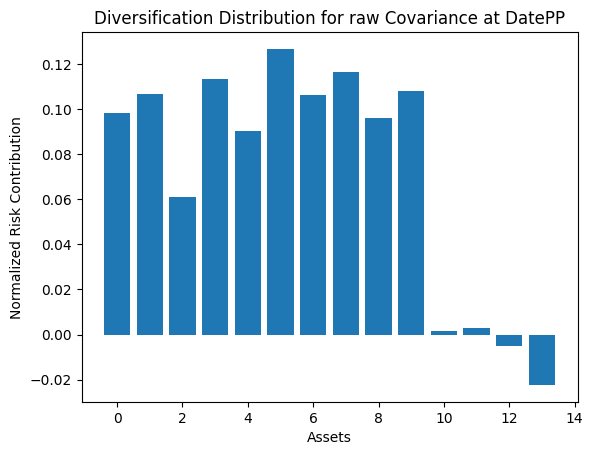

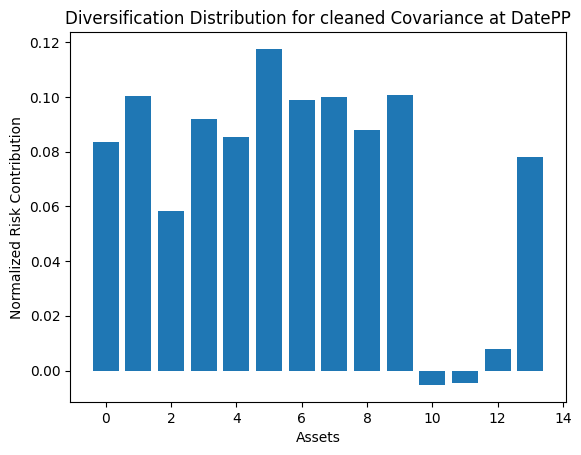

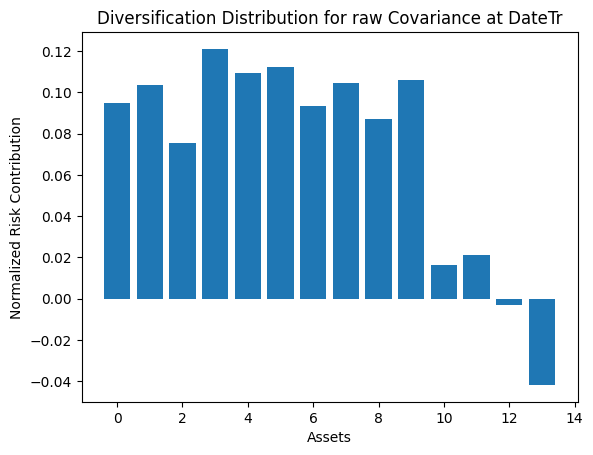

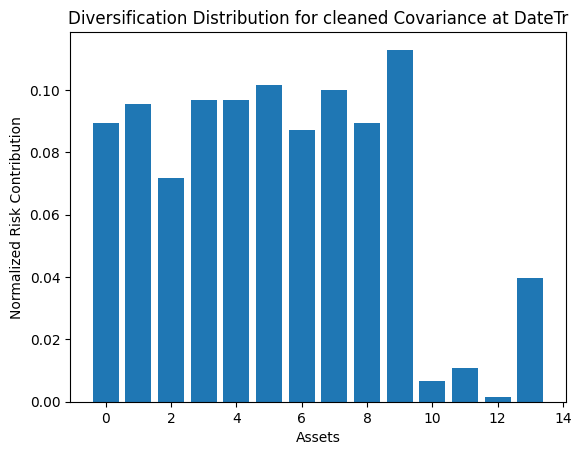

In [182]:
def effective_number_of_bets(risk_contributions):
    total_risk = np.sum(risk_contributions)
    squared_normalized_rc = (risk_contributions / total_risk) ** 2
    ENB = 1 / np.sum(squared_normalized_rc)
    return ENB

ENB_raw_datePP = effective_number_of_bets(RC_raw_datePP)
ENB_cleaned_datePP = effective_number_of_bets(RC_cleaned_datePP)
ENB_raw_dateTr = effective_number_of_bets(RC_raw_dateTr)
ENB_cleaned_dateTr = effective_number_of_bets(RC_cleaned_dateTr)

print(f"Effective Number of Bets for Raw Covariance at DatePP: {ENB_raw_datePP}")
print(f"Effective Number of Bets for Cleaned Covariance at DatePP: {ENB_cleaned_datePP}")
print(f"Effective Number of Bets for Raw Covariance at DateTr: {ENB_raw_dateTr}")
print(f"Effective Number of Bets for Cleaned Covariance at DateTr: {ENB_cleaned_dateTr}")

def plot_diversification_distribution(risk_contributions, title):
    total_risk = np.sum(risk_contributions)
    normalized_rc = risk_contributions / total_risk
    plt.bar(range(len(normalized_rc)), normalized_rc)
    plt.title(title)
    plt.xlabel('Assets')
    plt.ylabel('Normalized Risk Contribution')
    plt.show()

plot_diversification_distribution(RC_raw_datePP, 'Diversification Distribution for raw Covariance at DatePP')
plot_diversification_distribution(RC_cleaned_datePP, 'Diversification Distribution for cleaned Covariance at DatePP')
plot_diversification_distribution(RC_raw_dateTr, 'Diversification Distribution for raw Covariance at DateTr')
plot_diversification_distribution(RC_cleaned_dateTr, 'Diversification Distribution for cleaned Covariance at DateTr')

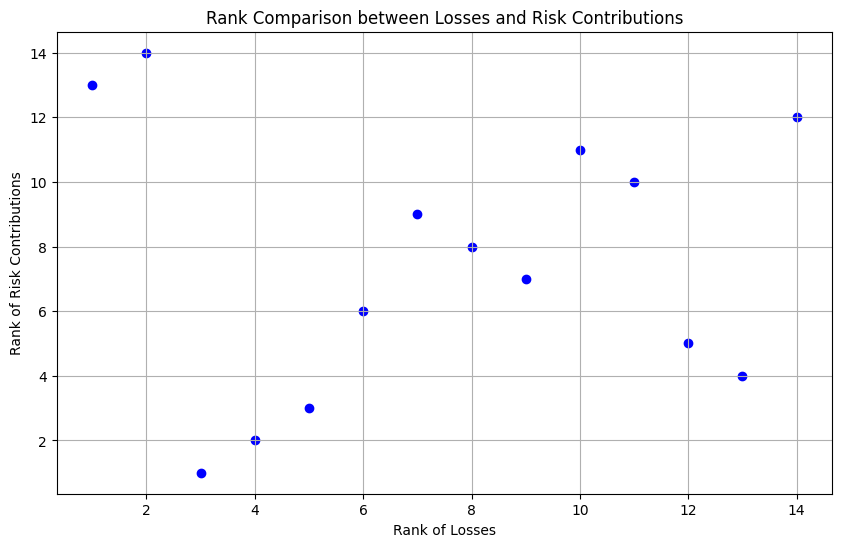

Kendall's Tau: 0.09890109890109891, P-value: 0.667174486232646


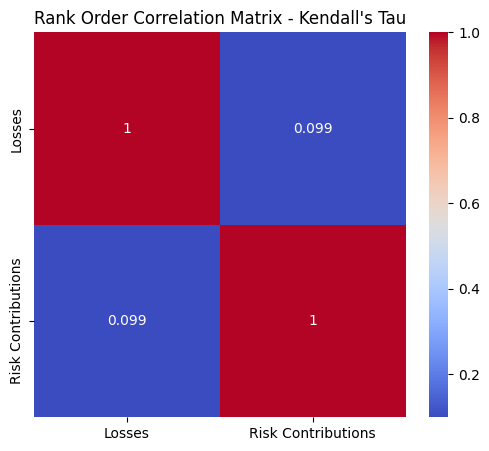

In [183]:
returns = df.iloc[index_dateTr : index_dateTr+1]  # Replace with the actual returns data for the trough date
risk_contributions = RC_cleaned_dateTr
losses = -returns
losses_rank = stats.rankdata(losses)
rc_rank = stats.rankdata(risk_contributions)

plt.figure(figsize=(10, 6))
plt.scatter(losses_rank, rc_rank, color='blue')
plt.title("Rank Comparison between Losses and Risk Contributions")
plt.xlabel("Rank of Losses")
plt.ylabel("Rank of Risk Contributions")
plt.grid(True)
plt.show()

# Calculate Kendall's Tau for rank order correlation
tau, p_value = stats.kendalltau(losses_rank, rc_rank)
print(f"Kendall's Tau: {tau}, P-value: {p_value}")

correlation_matrix = np.array([[1, tau], [tau, 1]])
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', xticklabels=['Losses', 'Risk Contributions'], yticklabels=['Losses', 'Risk Contributions'])
plt.title("Rank Order Correlation Matrix - Kendall's Tau")
plt.show()


**Risk based Portfolio**

In [184]:
%pip install riskfolio-lib

100579.01s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


In [185]:
import riskfolio as rp

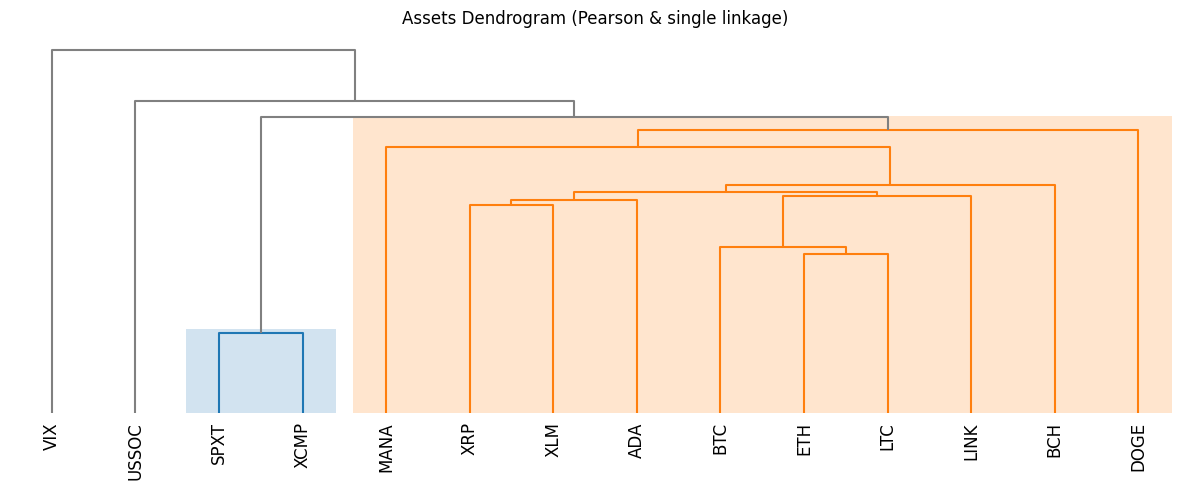

In [186]:
def minimum_variance_portfolio(cov_matrix): 
    n = cov_matrix.shape[0]
    w = cp.Variable(n)
    risk = cp.quad_form(w, cov_matrix)
    prob = cp.Problem(cp.Minimize(risk), 
                      [cp.sum(w) == 1, 
                       w >= 0])
    prob.solve()
    return w.value

def equal_risk_contribution_portfolio(cov_matrix, c=0):
    n = cov_matrix.shape[0]
    w_init = np.ones(n) / n
    def objective(w):
        return np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
    def constraint(w):
        return np.sum(np.log(w)) - c
    bounds = [(0, None) for _ in range(n)]
    cons = ({'type': 'ineq', 'fun': constraint})
    result = minimize(objective, w_init, method='SLSQP', bounds=bounds, constraints=cons)

    # Check if the solver converged
    if result.success:
        normalized_arr = result.x / np.sum(result.x)
        return normalized_arr
    else:
        raise ValueError("Optimization did not converge: " + result.message)


def minimum_effective_number_of_bets_portfolio(cov_matrix):
    # Define the objective function to be minimized (negative entropy for maximization)
    def objective_function(w):
        p = np.square(w) * np.diag(cov_matrix) / (w.T @ cov_matrix @ w)
        # To avoid log(0) we add a small number inside the log
        entropy = -np.sum(p * np.log(np.maximum(p, 1e-8)))
        return entropy
    def constraint_sum_of_weights(w):
        return np.sum(w) - 1
    x0 = np.full(cov_matrix.shape[0], 1.0 / cov_matrix.shape[0])
    bounds = [(0, None) for _ in range(cov_matrix.shape[0])]
    constraints = (
        {'type': 'eq', 'fun': constraint_sum_of_weights},
    )
    result = minimize(objective_function, x0, method='SLSQP', bounds=bounds, constraints=constraints)
    if not result.success:
        raise ValueError('Optimization failed: ' + result.message)
    return result.x

# Plotting Assets Clusters
ax = rp.plot_dendrogram(returns=df,
                        codependence='pearson',
                        linkage='single',
                        k=None,
                        max_k=10,
                        leaf_order=True,
                        ax=None)

def hierarchical_risk_parity_portfolio(y: str, codependence: str):
    # Validate the codependence argument
    if codependence not in {'pearson', 'spearman', 'kendall'}:
        raise ValueError("codependence must be one of 'pearson', 'spearman', or 'kendall'")

    index_datePP = df.index.get_loc(datePP)
    index_dateTr = df.index.get_loc(dateTr)
    
    # Building the portfolio object based on the date
    if y == datePP:
        port = rp.HCPortfolio(returns=df.iloc[0:index_datePP])
    elif y == dateTr:
        port = rp.HCPortfolio(returns=df.iloc[0:index_dateTr])
    else:
        raise ValueError("y must be either datePP or dateTr")
    
    # Estimate optimal portfolio
    model = 'HRP' # Could be HRP or HERC
    rm = 'MV' # Risk measure used, this time will be variance
    rf = 0.05 # Risk free rate offered by a government bond
    linkage = 'single' # Linkage method used to build clusters
    max_k = 10 # Max number of clusters used in two difference gap statistic, only for HERC model
    leaf_order = True # Consider optimal order of leafs in dendrogram

    w = port.optimization(model=model,
                          codependence=codependence,
                          rm=rm,
                          rf=rf,
                          linkage=linkage,
                          max_k=max_k,
                          leaf_order=leaf_order)

    return w

In [187]:
# Calculate portfolios for datePP
min_var_portfolio_datePP = minimum_variance_portfolio(cov_matrix_datePP)
erc_portfolio_datePP = equal_risk_contribution_portfolio(cov_matrix_datePP)
menb_portfolio_datePP = minimum_effective_number_of_bets_portfolio(cov_matrix_datePP)
hrp_portfolio_datePP = hierarchical_risk_parity_portfolio(datePP, "pearson")

# Calculate portfolios for dateTr
min_var_portfolio_dateTr = minimum_variance_portfolio(cov_matrix_dateTr)
erc_portfolio_dateTr = equal_risk_contribution_portfolio(cov_matrix_dateTr)
menb_portfolio_dateTr = minimum_effective_number_of_bets_portfolio(cov_matrix_dateTr)
hrp_portfolio_dateTr = hierarchical_risk_parity_portfolio(dateTr, "pearson")

# Print the results
print("Minimum Variance Portfolio at datePP:", min_var_portfolio_datePP)
print("Equal Risk Contribution Portfolio at datePP:", erc_portfolio_datePP)
print("Minimum Effective Number of Bets Portfolio at datePP:", menb_portfolio_datePP)
print("Hierarchical Risk Parity Portfolio at datePP:", hrp_portfolio_datePP, "pearson")

print("Minimum Variance Portfolio at dateTr:", min_var_portfolio_dateTr)
print("Equal Risk Contribution Portfolio at dateTr:", erc_portfolio_dateTr)
print("Minimum Effective Number of Bets Portfolio at dateTr:", menb_portfolio_dateTr)
print("Hierarchical Risk Parity Portfolio at dateTr:", hrp_portfolio_dateTr, "pearson")


Minimum Variance Portfolio at datePP: [-3.80e-15 7.25e-15 -4.15e-16 1.31e-14 5.09e-15 4.63e-15 4.04e-15 3.19e-15
 -6.98e-15 3.41e-03 9.18e-01 1.04e-03 1.09e-02 6.64e-02]
Equal Risk Contribution Portfolio at datePP: [6.71e-03 5.70e-03 1.05e-02 5.74e-03 7.09e-03 5.00e-03 6.03e-03 5.53e-03
 6.89e-03 6.17e-03 5.86e-01 2.06e-01 6.59e-02 7.66e-02]
Minimum Effective Number of Bets Portfolio at datePP: [6.11e-02 7.87e-02 1.06e-01 4.67e-02 8.30e-02 6.28e-02 7.87e-02 5.40e-02
 7.56e-02 6.47e-02 1.45e-01 1.43e-01 0.00e+00 1.52e-17]
Hierarchical Risk Parity Portfolio at datePP:         weights
ADA    0.004089
BCH    0.004499
BTC    0.021332
DOGE   0.002284
ETH    0.012856
LINK   0.006187
LTC    0.006546
MANA   0.004398
XLM    0.004843
XRP    0.004403
SPXT   0.521279
XCMP   0.343325
USSOC  0.051847
VIX    0.012113 pearson
Minimum Variance Portfolio at dateTr: [5.50e-18 1.91e-18 3.88e-18 3.67e-18 2.34e-18 3.21e-18 1.99e-02 3.66e-18
 1.48e-18 3.48e-19 3.87e-01 5.64e-18 5.04e-01 8.91e-02]
Equal Risk C

We will now modify the HRP protfolio optimisation to use the following distance measure presentend by Embrechts, Mcneil & Straumann 2002: $$\delta_1
(X,Y) = 12\int_{0}^{1} \int_{0}^{1} |C(u,w) - uv| \, du \, dv$$. In the Riskfolio library, this boils down to using the the Spearman correlation matrix for our tree clustering, and it is done with the following code :

alternative Hierarchical Risk Parity Portfolio at datePP:         weights
ADA    0.007428
BCH    0.010080
BTC    0.018772
DOGE   0.005116
ETH    0.009290
LINK   0.008481
LTC    0.007374
MANA   0.005215
XLM    0.012474
XRP    0.006283
SPXT   0.441631
XCMP   0.407156
USSOC  0.043925
VIX    0.016774
alternative Hierarchical Risk Parity Portfolio at dateTr:         weights
ADA    0.006497
BCH    0.004928
BTC    0.017893
DOGE   0.002539
ETH    0.008821
LINK   0.007147
LTC    0.007230
MANA   0.004740
XLM    0.008647
XRP    0.006461
SPXT   0.438192
XCMP   0.415216
USSOC  0.058010
VIX    0.013681


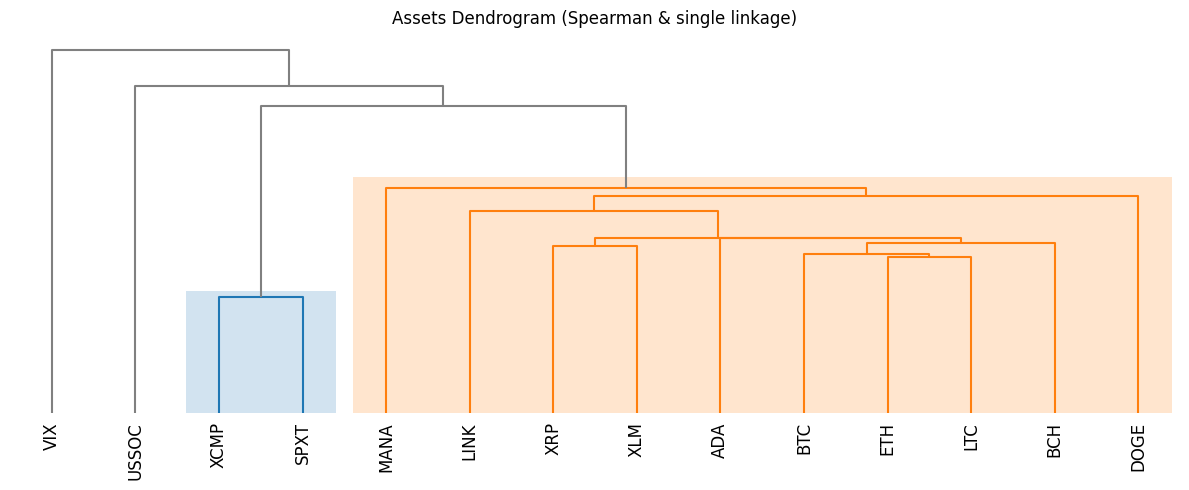

In [188]:
#plot dendogram
# Plotting Assets Clusters
ax = rp.plot_dendrogram(returns=df,
                        codependence='spearman',
                        linkage='single',
                        k=None,
                        max_k=10,
                        leaf_order=True,
                        ax=None)

# Calculate portfolio for datePP
alt_HRP_port_datePP = hierarchical_risk_parity_portfolio(datePP, "spearman")

# Calculate portfolios for dateTr
alt_HRP_port_dateTr = hierarchical_risk_parity_portfolio(dateTr, "spearman")

# Print the results
print("alternative Hierarchical Risk Parity Portfolio at datePP:", alt_HRP_port_datePP)
print("alternative Hierarchical Risk Parity Portfolio at dateTr:", alt_HRP_port_dateTr)

We also run the same code with kendall's tau as codependence, but did not include it in the report as we do not find anything significant.

alternative Hierarchical Risk Parity Portfolio at datePP:         weights
ADA    0.007428
BCH    0.003221
BTC    0.035803
DOGE   0.003770
ETH    0.007514
LINK   0.008481
LTC    0.005965
MANA   0.005215
XLM    0.012474
XRP    0.005196
SPXT   0.441631
XCMP   0.407156
USSOC  0.043925
VIX    0.012220
alternative Hierarchical Risk Parity Portfolio at dateTr:         weights
ADA    0.006497
BCH    0.004411
BTC    0.019430
DOGE   0.002338
ETH    0.008047
LINK   0.007147
LTC    0.006596
MANA   0.004740
XLM    0.008879
XRP    0.006819
SPXT   0.438192
XCMP   0.415216
USSOC  0.058010
VIX    0.013681


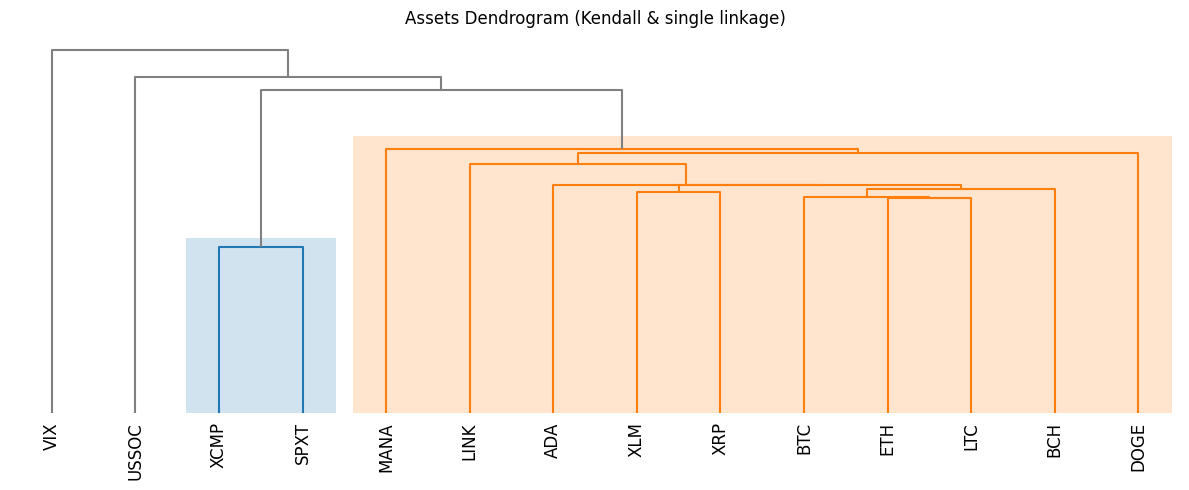

In [189]:
ax = rp.plot_dendrogram(returns=df,
                        codependence='kendall',
                        linkage='single',
                        k=None,
                        max_k=10,
                        leaf_order=True,
                        ax=None)

# Calculate portfolio for datePP
alt_HRP_port_datePP = hierarchical_risk_parity_portfolio(datePP, "kendall")

# Calculate portfolios for dateTr
alt_HRP_port_dateTr = hierarchical_risk_parity_portfolio(dateTr, "kendall")

# Print the results
print("alternative Hierarchical Risk Parity Portfolio at datePP:", alt_HRP_port_datePP)
print("alternative Hierarchical Risk Parity Portfolio at dateTr:", alt_HRP_port_dateTr)